# Isothermal hydration gravimetry and calorimetry
## data reduction and analysis

### Import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sig
from scipy.optimize import curve_fit
import sklearn.decomposition as factor
%matplotlib inline

## define IHGC functions

In [2]:
def import_csv(path, delimiter='\t'):
    """ function to import csv data from the specified path and convert to numpy array """
    
    data = np.genfromtxt(path, delimiter=delimiter, dtype=float, names=True)
    
    return data

In [3]:
def settle_clip(data, start_time=0):
    """ function to clip data from start of a scan """
    
    clip_data = np.delete(data, slice(start_time), axis=0)
    
    return clip_data

In [4]:
def mass_steps(data, start=1800, steps=20, step_size=3600):
    """ function to find the mass at specific time intervals """
    
    steps = range(start, steps*step_size+1, step_size)
    
    masses = [data[i] for i in steps]
    
    
    mass_diff = np.diff(masses)
    mass_percent = np.cumsum(mass_diff / masses[0])
    mass_percent = np.insert(mass_percent, 0, 0)
    
    
    return masses, mass_diff, mass_percent

In [5]:
def rh_steps(data, start=1800, steps=20, step_size=3600):
    """ function to find the RH at specific time intervals """
    
    steps = range(start, steps*step_size+1, step_size)
    
    rhs = [data[i] for i in steps]
    #rhs = np.insert(rhs, 0, rhs[0])
    
    return rhs

In [6]:
def plot_chgc(data, save=False, save_path=''):
    """ Plot the raw CHGC data in five panels:
            1. Reference temperature
            2. Sample temperature
            3. Weight
            4. Heat Flow
            5. Relative Humidity
    """
    
    fig, axs = plt.subplots(5, 1, figsize=(32, 32))
    plt.rcParams.update({'font.size': 20})

    axs[0].plot(data['t'], data['Tr'], color='b')
    axs[0].set_xlabel('time [s]')
    axs[0].set_ylabel(r'reference temperature [$\degree$C]')

    axs[1].plot(data['t'], data['Ts'], color='b')
    axs[1].set_xlabel('time [s]')
    axs[1].set_ylabel(r'sample temperature [$\degree$C]')

    axs[2].plot(data['t'], data['Weight'], color='k')
    axs[2].set_xlabel('time [s]')
    axs[2].set_ylabel(r'weight [mg]')

    axs[3].plot(data['t'], data['HF'], color='r')
    axs[3].set_xlabel('time [s]')
    axs[3].set_ylabel(r'heat flow [mW]')

    axs[4].plot(data['t'], data['RH'], color='g')
    axs[4].set_xlabel('time [s]')
    axs[4].set_ylabel(r'relative humidity [%]')
    axs[4].set_ylim([0,100])

    plt.show

    if save:
        plt.savefig(save_path)

In [7]:
def smooth(data, sm=0.01, mode='same'):
    """ smooth data with a convolution kernel and resample to original length """
    
    data_len = len(data)

    kernel = int(sm * data_len)
    if kernel == 0: kernel = 1
    samples = np.ones(kernel)/kernel
    corr = np.convolve(data, samples, mode=mode)

#     corr_len = len(corr)
#     trim_len = corr_len - data_len
    
#     if abs(trim_len) % 2 > 0:
#         trim = trim_len // 2
#         data_smooth = corr[trim:-(trim+1)]
                
#     else:
#         trim = int(trim_len / 2)
#         data_smooth = corr[trim:-trim]
       
    return corr

In [8]:
def normalize(data):
    """" normalize data by subtracting min and dividing by max """
    
    sign = np.sign(np.max(data))
    
    if sign > 0:
        norm_data = (data - np.min(data)) / np.max(data)
    else:
        norm_data = (data - np.max(data)) / np.min(data)
        
    return norm_data

In [9]:
def phase_lag(data1, data2, mode='full'):
    """ find phase lag between two signals by cross-correlation """
    
    conv = np.convolve(data1, data2, mode=mode)
    peak = np.argmax(np.abs(conv))
    
    return peak, conv

In [10]:
def nyquist_fft(data, samp=1):
    """ take Fourier transform, split at the Nyquist frequency and retain only the first half, treating odd lengths by interpolating """
    
    data_fft = np.fft.fft(data)
    data_fft_freq = np.fft.fftfreq(len(data))
    
    if len(data_fft_freq) % 2 > 0:
        trim = (len(data_fft_freq) - 1) // 2
    else:
        trim = len(data) // 2
    
    data_fft = data_fft[:trim]
    data_fft_freq = data_fft_freq[:trim]
    
    return data_fft_freq, data_fft

In [11]:
def fft_plot(data, smoothing=0.01, plot=True):
    """ function to plot the fft and cepstrum  """
    
    # --- take fft and get frequencies
    data_fft = np.fft.fft(data)
    data_fft_time = np.arange(len(data_fft))
    data_fft_freq = np.fft.rfftfreq(len(data))
    data_fft_freq_len = len(data_fft_freq)
    
    if data_fft_freq_len % 2 > 0:
        data_fft_freq_len = data_fft_freq_len - 1
        
    #--- shift fft and smooth
    data_fft_shift = np.fft.fftshift(data_fft)[data_fft_freq_len:]
    data_fft_shift_smooth = smooth(data_fft_shift, sm=smoothing)
        
    data_fft_shift_power = 20 * np.log10(abs(data_fft_shift))
    data_fft_shift_power_smooth = smooth(data_fft_shift_power, sm=smoothing)
    
    # --- ifft amp
    data_fft_amp = np.abs(np.fft.ifft(np.abs(data_fft)))[data_fft_freq_len:]
    data_fft_amp_smooth = smooth(data_fft_amp, sm=smoothing)
    
    # --- cepstrum
    data_fft_cep = np.abs(np.fft.ifft(20 * np.log10(np.abs(data_fft))))
    data_fft_cep_smooth = smooth(data_fft_cep, sm=smoothing)
    
    
    if plot: # --- make plots
        
        fig, axs = plt.subplots(2, 2, figsize=(24, 12))
        plt.rcParams.update({'font.size': 20})

        ax = np.ndarray.flatten(axs)

        ax[0].plot(data_fft_freq, data_fft_shift_power, color='k')
        ax[0].plot(data_fft_freq, data_fft_shift_power_smooth, color='r')
        ax[0].set_xlabel(r'1/time [$s^{-1}$]')
        ax[0].set_ylabel(r'power [dB]')

        ax[1].plot(np.log(data_fft_time[:data_fft_freq_len]), data_fft_cep[:data_fft_freq_len], color='k')
        ax[1].plot(np.log(data_fft_time[:data_fft_freq_len]), data_fft_cep_smooth[:data_fft_freq_len], color='r')
        ax[1].set_xlabel(r'ln time [s]')
        ax[1].set_ylabel(r'magnitude [au]')

        ax[2].plot(np.log(data_fft_freq), data_fft_shift_power, color='k')
        ax[2].plot(np.log(data_fft_freq), data_fft_shift_power_smooth, color='r')
        ax[2].set_xlabel(r'1/time $[s^{-1}$]')
        ax[2].set_ylabel(r'power [dB]')

        ax[3].plot(data_fft_time[:data_fft_freq_len], 20*np.log10(data_fft_cep[:data_fft_freq_len]), color='k')
        ax[3].plot(data_fft_time[:data_fft_freq_len], 20*np.log10(data_fft_cep_smooth[:data_fft_freq_len]), color='r')
        ax[3].set_xlabel(r'time [s]')
        ax[3].set_ylabel(r'log magnitude [dB]')
        ax[3].set_ylim([-50, np.max(20*np.log10(data_fft_cep_smooth[:data_fft_freq_len]))])
        
        plt.show

    return data_fft_freq, data_fft_shift_power, data_fft_time[:data_fft_freq_len], data_fft_cep[:data_fft_freq_len]

In [12]:
def plot_chgc_x(data, plot=True, save=False, save_path=''):
    """ Plot the raw CHGC data in five panels:
            1. Fourier transform of sample temperature
            2. Weight gradient
            3. Heat Flow
            4. Relative Humidity gradient
    """
    
    # fft of sample tempearture
    freq, power, _, _ = fft_plot(data['Ts'], plot=False)
    power_smooth = smooth(power)
    
    # grad time
    t_g = smooth(data['t'], mode='valid')
    
    # gradient of weight
    w_g = np.gradient(smooth(data['Weight'], mode='valid'))
    
    # gradient of relative humidity
    rh_g = np.gradient(smooth(data['RH'], mode='valid'))
    
    if plot:
        fig, axs = plt.subplots(4, 1, figsize=(32, 28))
        plt.rcParams.update({'font.size': 20})

        axs[0].plot(freq, power, color='b')
        axs[0].plot(freq, power_smooth, color='r')
        axs[0].set_xlabel(r'1/time [$s^{-1}$]')
        axs[0].set_ylabel(r'power [dB]')

        axs[1].plot(t_g, w_g, color='k')
        axs[1].set_xlabel('time [s]')
        axs[1].set_ylabel(r'$\delta$weight/$\delta$t [mg/s]')

        axs[2].plot(data['t'], data['HF'], color='r')
        axs[2].set_xlabel('time [s]')
        axs[2].set_ylabel(r'heat flow [mW]')

        axs[3].plot(t_g, rh_g, color='g')
        axs[3].set_xlabel('time [s]')
        axs[3].set_ylabel(r'$\delta$RH/$\delta$t [%/s]')

        plt.show

    if save:
        plt.savefig(save_path)
        
    return t_g, w_g, rh_g


In [13]:
def freq_find(cep, prom=0.01, plot=True):
    """ identify key spectral signatures from cepstrum for filtering """
    
    test_peaks = sig.find_peaks(cep, prominence=prom)

    if plot: # --- make plots
        fig, axs = plt.subplots(1, 2, figsize=(18, 6))
        plt.rcParams.update({'font.size': 20})
        axs[0].plot(test_peaks[0][:20], test_peaks[1]['prominences'][:20], color='k')
        axs[0].scatter(test_peaks[0][:20], test_peaks[1]['prominences'][:20], color='k')
        axs[0].hlines(np.max(test_peaks[1]['prominences'][20:]), np.min(test_peaks[0][:20]), np.max(test_peaks[0][:20]))

        axs[1].plot(test_peaks[0][20:], test_peaks[1]['prominences'][20:], color='k')
        axs[1].scatter(test_peaks[0][20:], test_peaks[1]['prominences'][20:], color='k')
        #axs[1].hlines(np.max(test_peaks[1]['prominences'][:20]), np.min(test_peaks[0][:20]), np.max(test_peaks[0][20:]))

In [14]:
def c_pad(data, length):
    """ pad data to 'length' by applying a buffer to either side
        if 'data' and 'length' are both even, buffer is symmetric
        if 'data' and 'length' are both odd, buffer is symmetric
        if 'data' and 'length' differ, an element of 'data' is removed
        default is to remove the last element of 'data'
    """
    
    lo = len(data)
    lb = length - lo
    
    if lb % 2 > 0:
        data = data[:-1]
        lo = len(data)
        lb = length - lo
        lb2 = lb // 2
        data_pad = np.pad(data, lb2, mode='edge')
    elif lb < 2:
        data_pad = data
    else:
        data_pad = np.pad(data, lb // 2, mode='edge')
    
    return data_pad

In [15]:
def hydration_integrate(data, r_min=0, interval=3600, plot=True):
    """ do stuff
    """
    
    # --- import heatflow data
    heat_data = data['HF']
    heat_zerod = heat_data - np.median(heat_data)
    
    # --- get smoothed curves 
    t_g, w_g, rh_g = plot_chgc_x(data, plot=False)
    
    # --- make mask using RH data
    rh_g_mask = 2 * rh_g / np.max(np.abs(rh_g))
    rh_g_mask = np.clip(np.round(c_pad(rh_g_mask, len(data['HF']))), -1, 1)
    rh_g_mask = np.roll(rh_g_mask, 290)
    
    # --- iterate over each cycle to fit background and integrate heatflow
    n_iter = int(len(data['HF']) / interval)
    int_mag = np.zeros(n_iter)
    all_int_array = np.zeros((n_iter, interval))
    for i in range(n_iter):
        x = interval * i
        start = r_min + x
        #start_bg = np.max([start - interval//4, 0])
        end = start + interval
        #end_bg = np.min([end + interval//4, len(data['HF'])])
                
        # --- import mass data
        mass_bg_i = data['Weight'][start:end] - np.min(data['Weight'][start:end])

        # apply mask to the raw heatflow data to get the background
        if np.sum(rh_g_mask[start:end]) >= 0:
            heat_bg = heat_zerod[start:end] * (-rh_g_mask[start:end] + 1)
            mass_bg = mass_bg_i * (-rh_g_mask[start:end] + 1)
        else:
            heat_bg = heat_zerod[start:end] * (rh_g_mask[start:end] + 1)
            mass_bg = mass_bg_i * (rh_g_mask[start:end] + 1)

        # --- find linear least squares fit of mass curve to heatflow background and subtract it
        A = np.vstack([mass_bg, np.ones(len(heat_bg))]).T
        fit_m, fit_b = np.linalg.lstsq(A, heat_bg, rcond=None)[0]
        heat_bgsub = heat_zerod[start:end] - (fit_m * mass_bg_i + fit_b)
        
        all_int_array[i] = heat_bgsub

#         # --- cumulative integration of peak area
#         sampling = np.diff(data['t'])
#         int_array = np.zeros(len(heat_bgsub)-1)
#         for idx, n in enumerate(heat_bgsub[:-1]):
#             int_array[idx] = 0.5 * (n + heat_bgsub[idx+1]) * sampling[idx]
        
#         int_cdf = np.cumsum(int_array * rh_g_mask[start+1:end]) 
#         int_ext = np.argmax(np.abs(int_cdf))
#         int_sign = np.sign(int_cdf[int_ext])
#         int_mag[i] = (np.max(np.abs(int_cdf)) - np.min(np.abs(int_cdf))) * int_sign
 
        
        if plot:
            fig, axs = plt.subplots(1, 2, figsize=(24, 6))
            axs[0].plot(c_pad(heat_zerod[start:end], len(heat_bg)), color='k')
            axs[0].plot(c_pad(heat_bgsub, len(heat_bg)), color='r')
            
            axs[1].plot(heat_bg, color='k')
            axs[1].plot(c_pad(fit_m * mass_bg_i + fit_b, len(heat_bg)))
            axs[1].plot(c_pad(rh_g_mask[start:end], len(heat_bg)), color='g')
            axs[1].set_ylim([-0.05,0.1])
            
            #axs[2].plot(int_cdf)
            
            plt.show
    
    # --- do PCA on exo/endotherms and fit dominant PCs to raw data
    signs = np.sum(all_int_array, axis=1) >= 0
    pca = factor.PCA()
    pca_pos = pca.fit(all_int_array[signs]).components_
    pca_neg = pca.fit(all_int_array[~signs]).components_
    #print(test_pca.explained_variance_ratio_)
    #print(test_pca.noise_variance_)
    
    n_inter = range(len(all_int_array))
    for idx in n_inter:
        if signs[idx]:
            A = np.vstack([-pca_pos[0], -pca_pos[1]]).T
            fit_m1, fit_m2 = np.linalg.lstsq(A, all_int_array[idx], rcond=None)[0]
            therm_int = np.trapz(fit_m1 * -pca_pos[0] + fit_m2 * -pca_pos[1])
            int_mag[idx] = therm_int
                
        elif ~signs[idx]:
            A = np.vstack([pca_pos[0], pca_pos[1]]).T
            fit_m1, fit_m2 = np.linalg.lstsq(A, all_int_array[idx], rcond=None)[0]
            therm_int = np.trapz(fit_m1 * pca_pos[0] + fit_m2 * pca_pos[1])
            int_mag[idx] = therm_int
                
        else: print('wtf')

    
    fig2, axs2 = plt.subplots(1, 3, figsize=(18, 6))
    for a in all_int_array:
        if np.sum(a) >= 0:
            axs2[0].plot(np.abs(a) / np.max(np.abs(a)))
        else:
            axs2[1].plot(a / np.max(np.abs(a)))
    
    rhs = [10, 20, 30, 40, 50, 60, 70, 80, 90, 95, 95, 90, 80, 70, 60, 50, 40, 30, 20, 10]
    axs2[2].plot(rhs, np.abs(int_mag), color='k')
    axs2[2].set_xlim([0,100])
    
        
    return int_mag, all_int_array

In [16]:
def hydration_quant(data, start=1800, steps=21, plot=True):
    """ quantify hydration isotherms """
    
    m, md, mr = mass_steps(data['Weight'], start=start, steps=steps)
    rh = rh_steps(data['RH'], start=start, steps=steps)
    dQ, _ = hydration_integrate(data, plot=False)
    dH = (dQ * 17.998) / (md * 1000) # [kJ/mol]
    
    if plot:
        fig, axs = plt.subplots(1, 2, figsize=(20, 6))
        plt.rcParams.update({'font.size': 20})

        axs[0].plot(rh, mr, color='k')
        axs[0].scatter(rh, mr, color='k')
        axs[0].fill_between(rh[:11], mr[:11], np.flip(mr[10:]), color='k', alpha=0.2)
        axs[0].set_xlabel(r'$\Delta$RH [%]')
        axs[0].set_ylabel(r'$\Delta$m [%]')
        axs[0].set_xlim([0,100])

        axs[1].plot(rh[1:], np.abs(dH), color='k')
        axs[1].scatter(rh[1:], np.abs(dH), color='k')
        axs[1].set_xlabel(r'$\Delta$RH [%]')
        axs[1].set_ylabel(r'$\Delta H_{hyd}$ [kJ/mol]')
        axs[1].set_xlim([0,100])

        plt.show;
    
    return rh, mr, dH

## Import data

In [17]:
mw86D = import_csv("/yourpath/MW2-86D_1.txt")
mw86E = import_csv("/yourpath/MW2-86E_1.txt")
mw86F = import_csv("/yourpath/MW2-86F_1.txt")
mw86G = import_csv("/yourpath/MW2-86G_1.txt")
mw86H = import_csv("/yourpath/MW2-86H_1.txt")

In [18]:
mw86D = settle_clip(mw86D, start_time=2700)
mw86E = settle_clip(mw86E, start_time=2700)
mw86F = settle_clip(mw86F, start_time=2700)
mw86G = settle_clip(mw86G, start_time=2700)
mw86H = settle_clip(mw86H, start_time=2700)

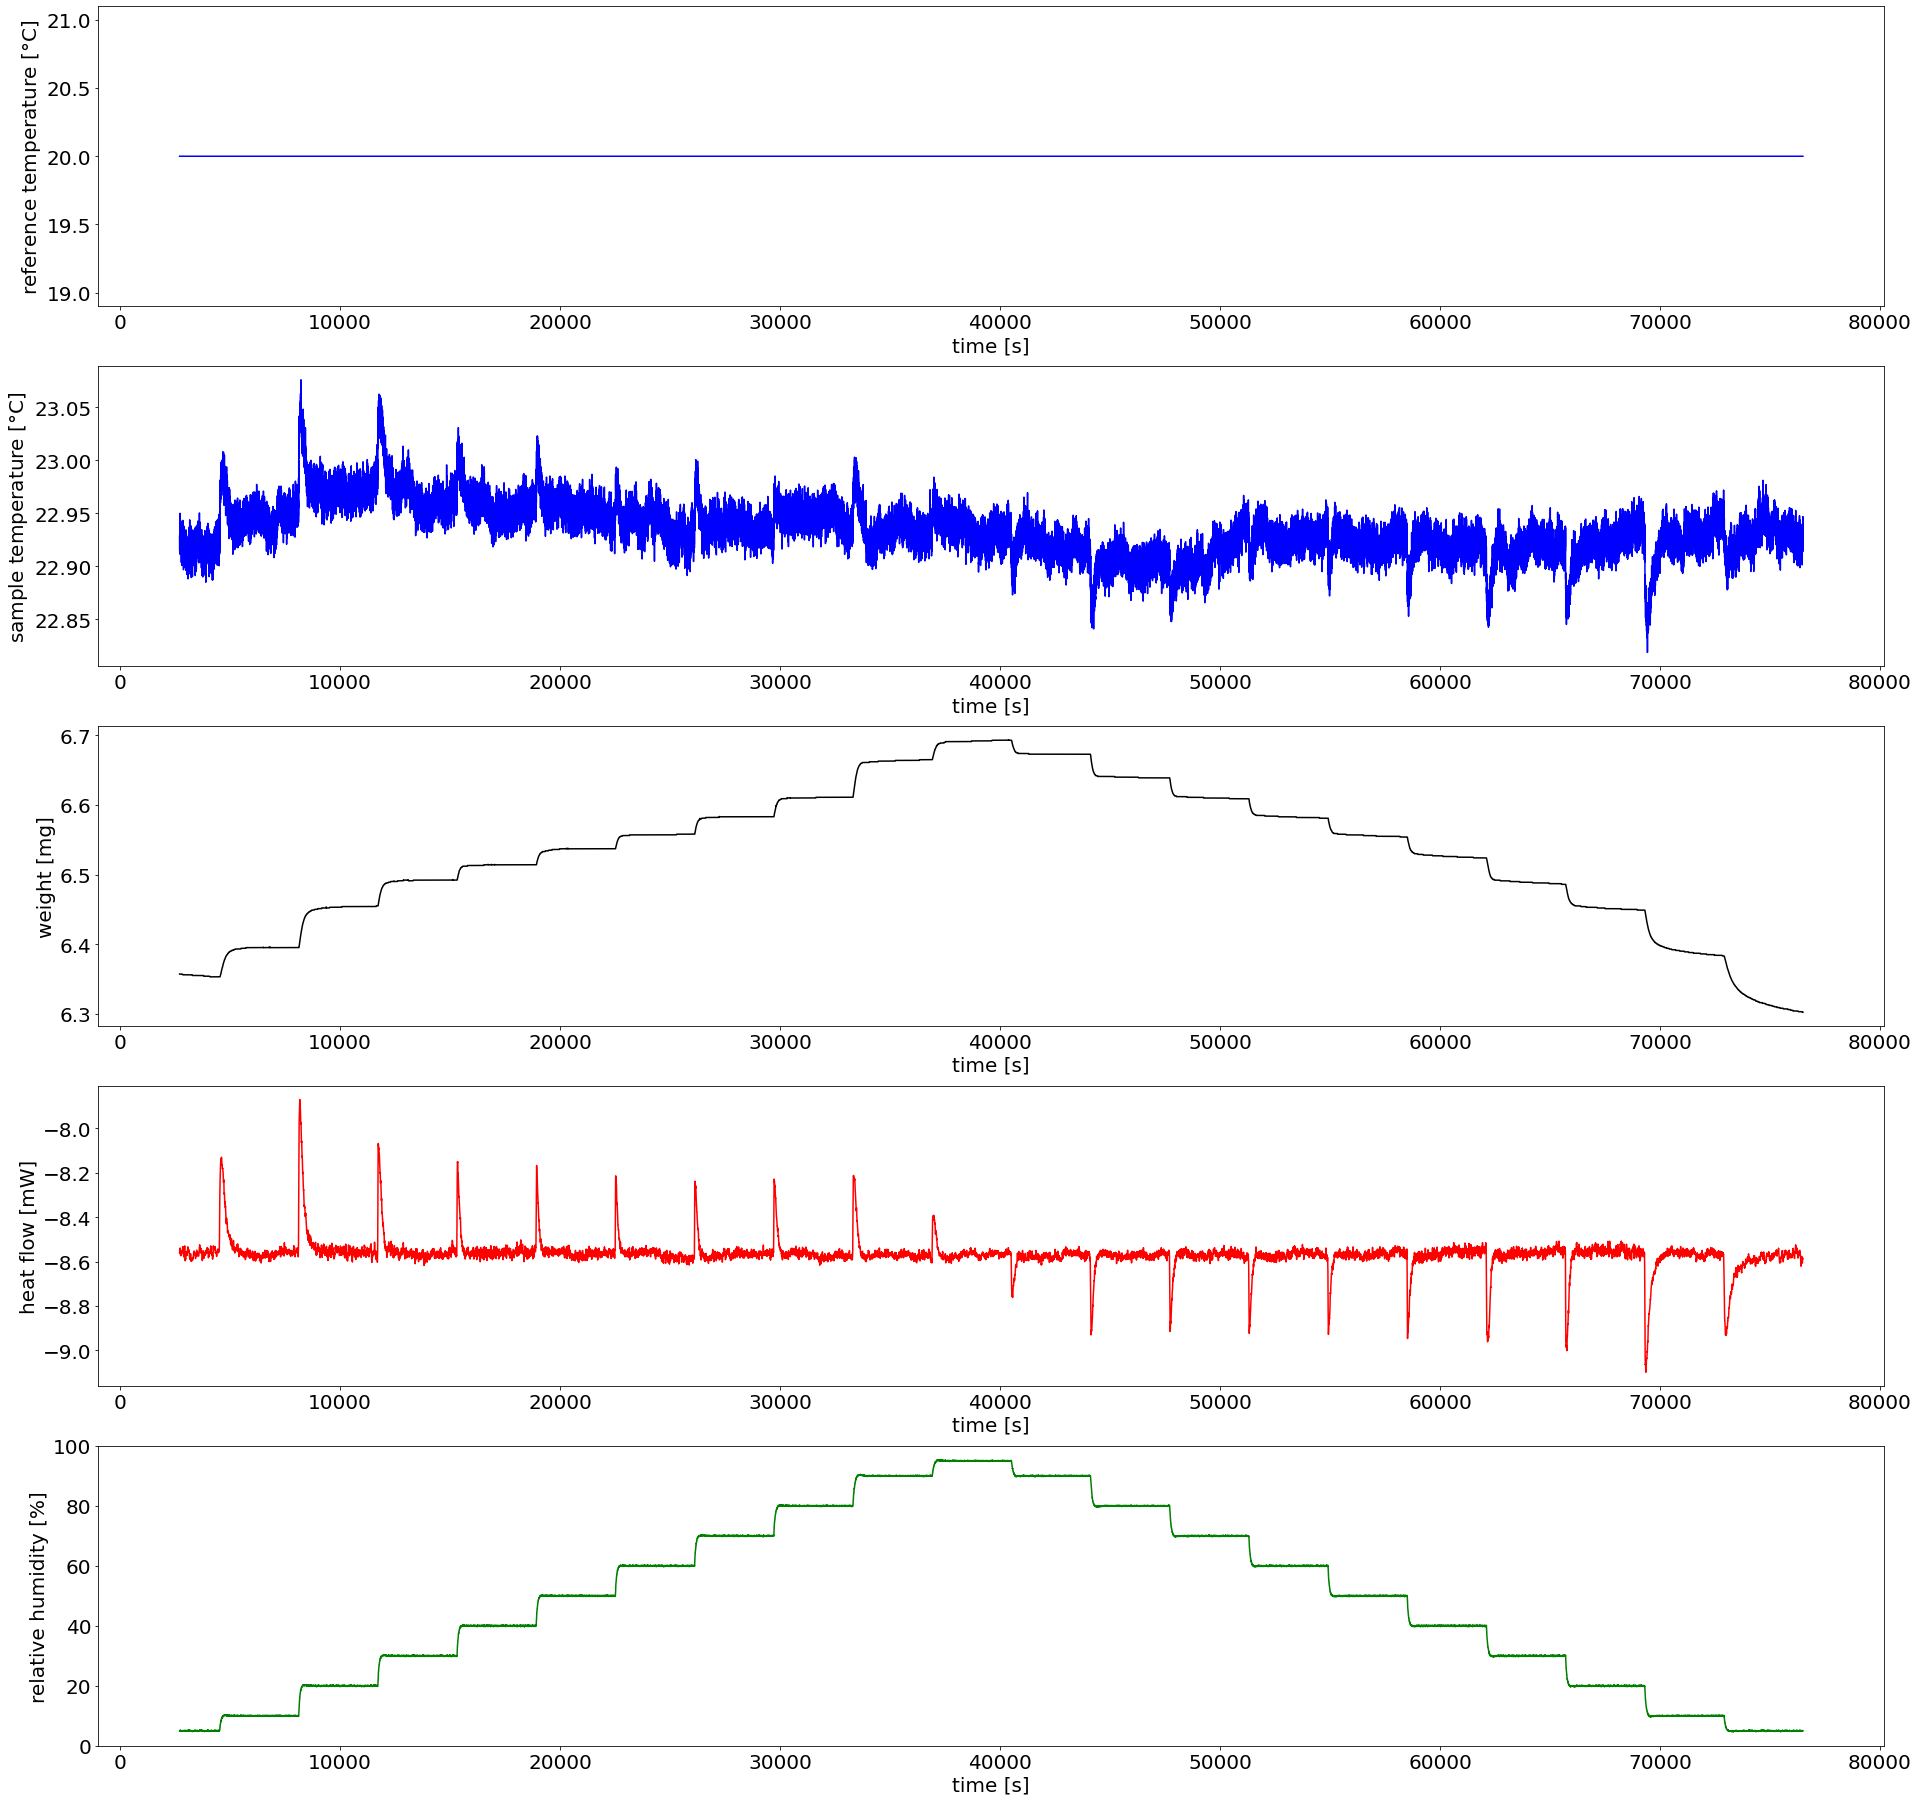

In [22]:
plot_chgc(mw86G)

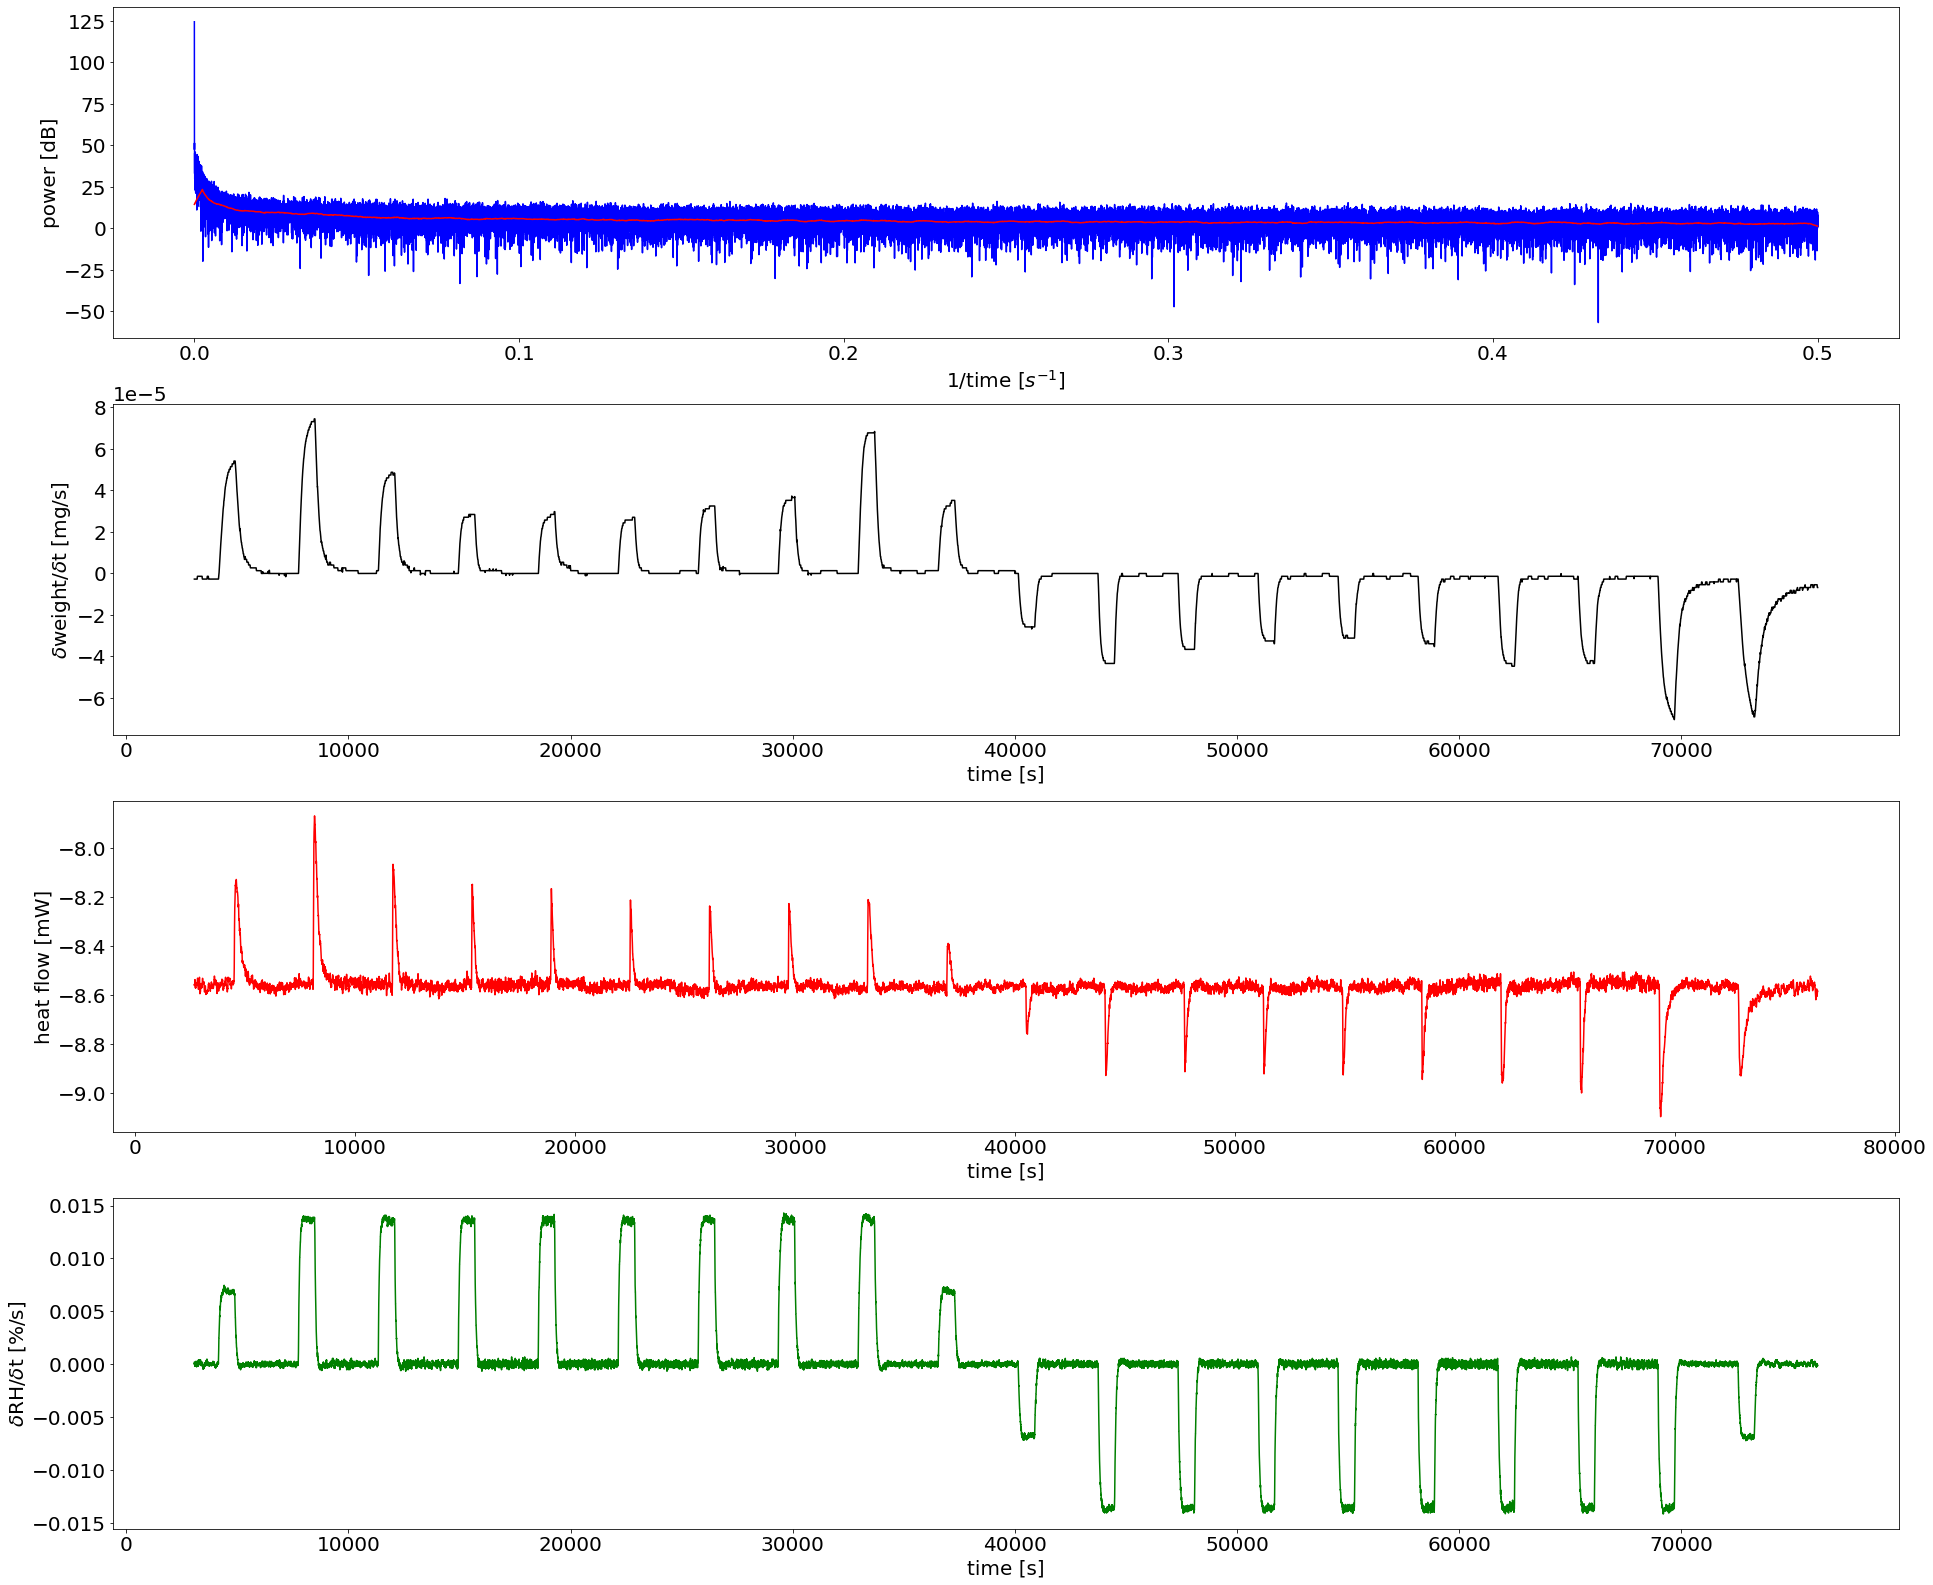

In [23]:
plot_chgc_x(mw86G);

/Users/whitta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


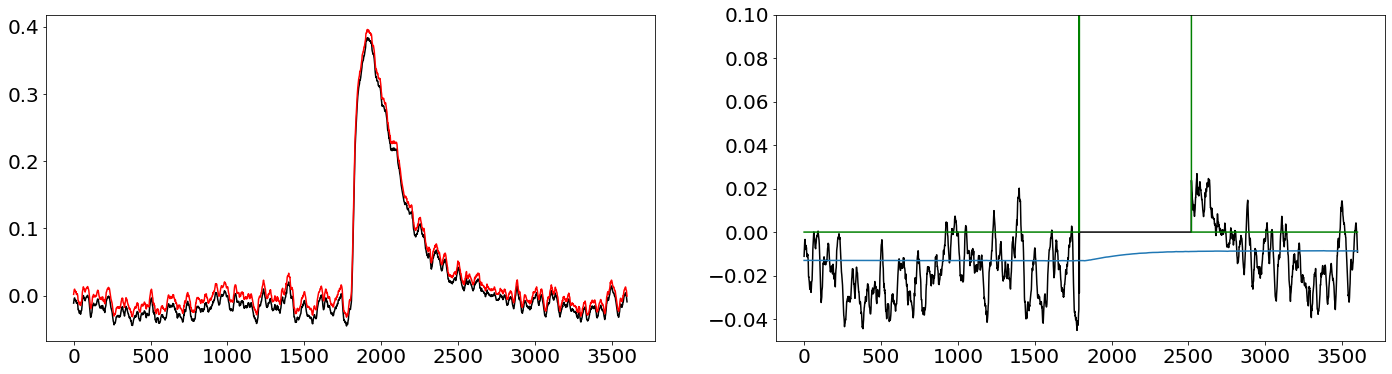

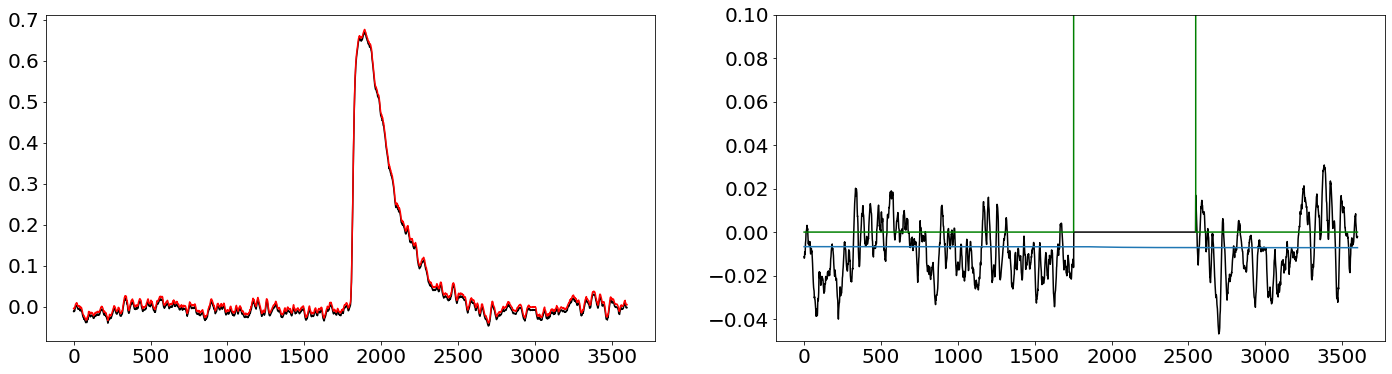

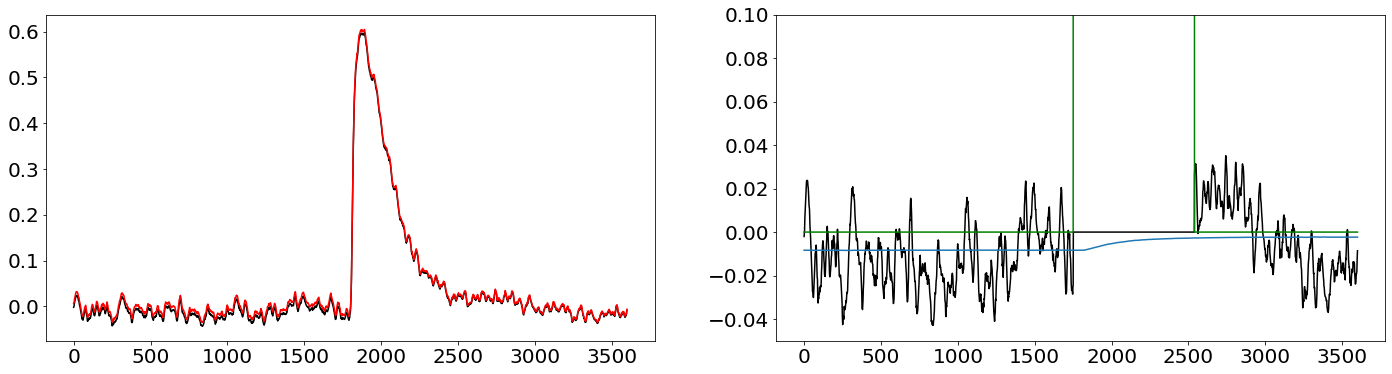

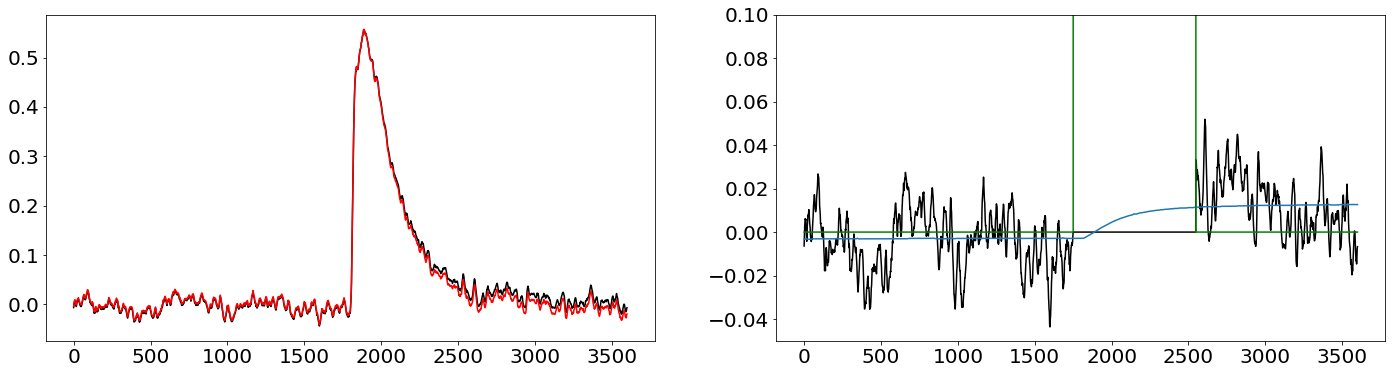

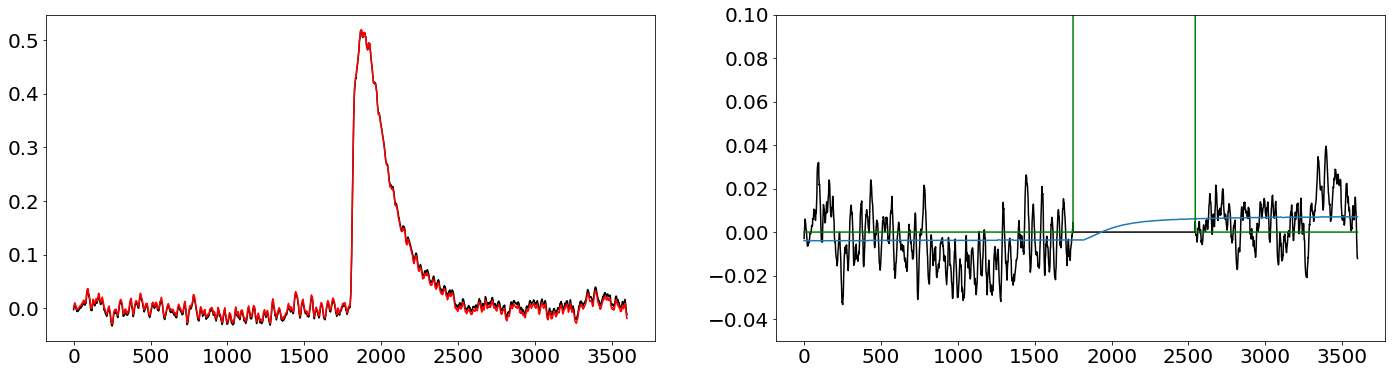

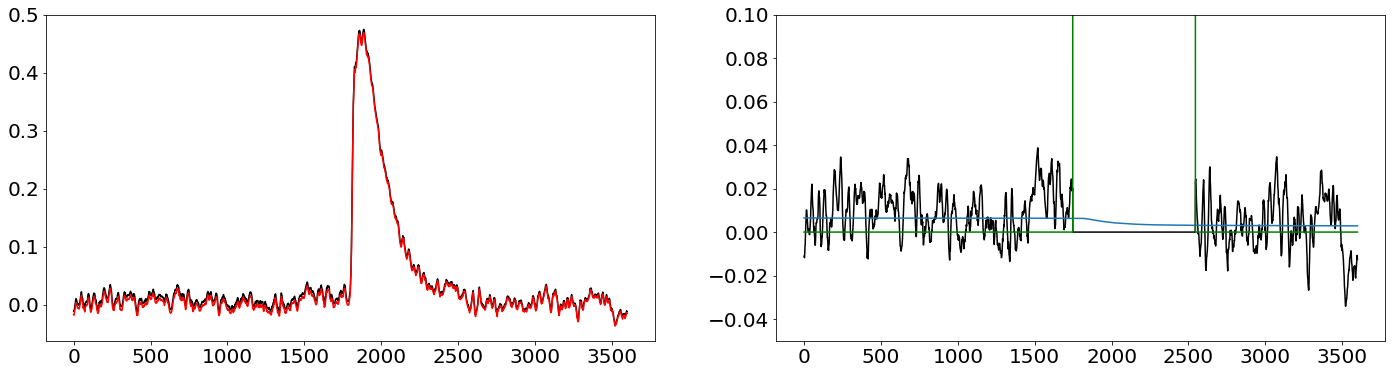

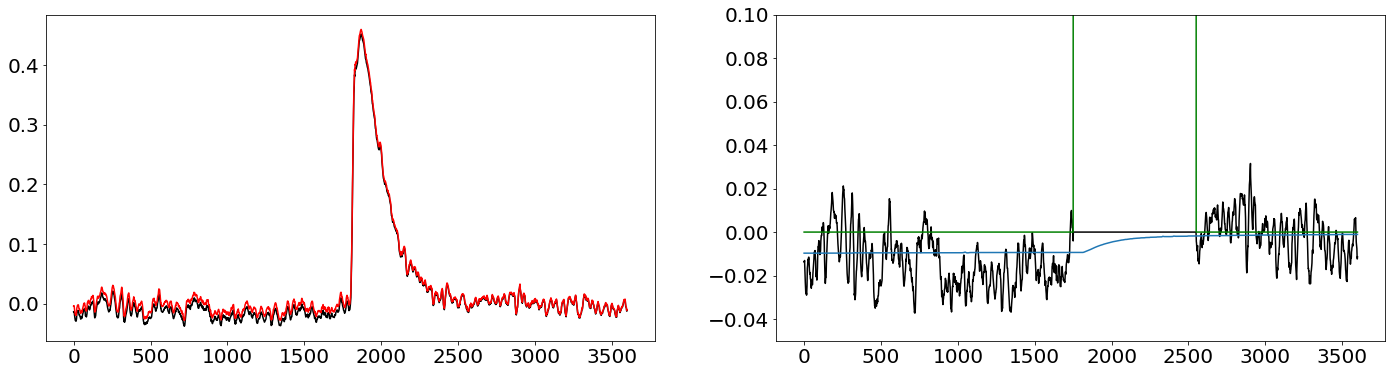

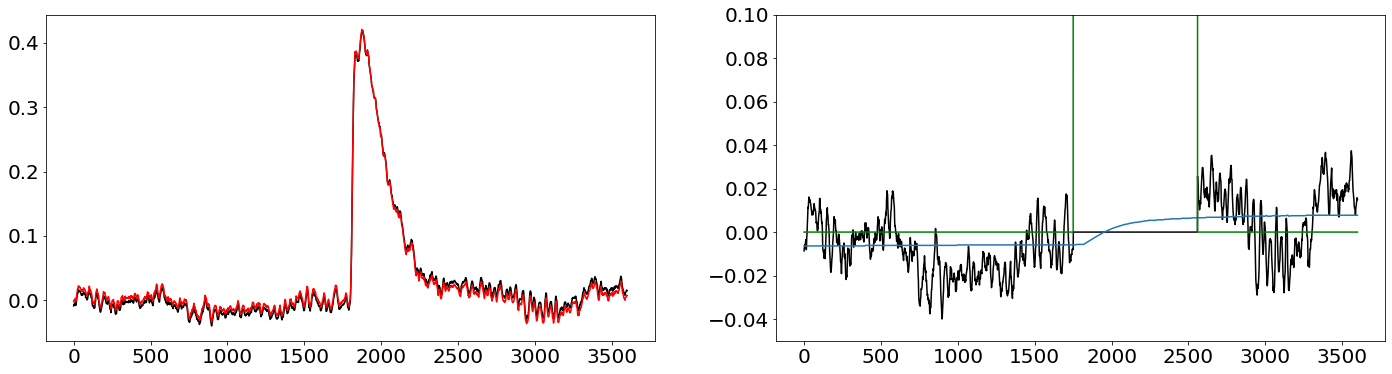

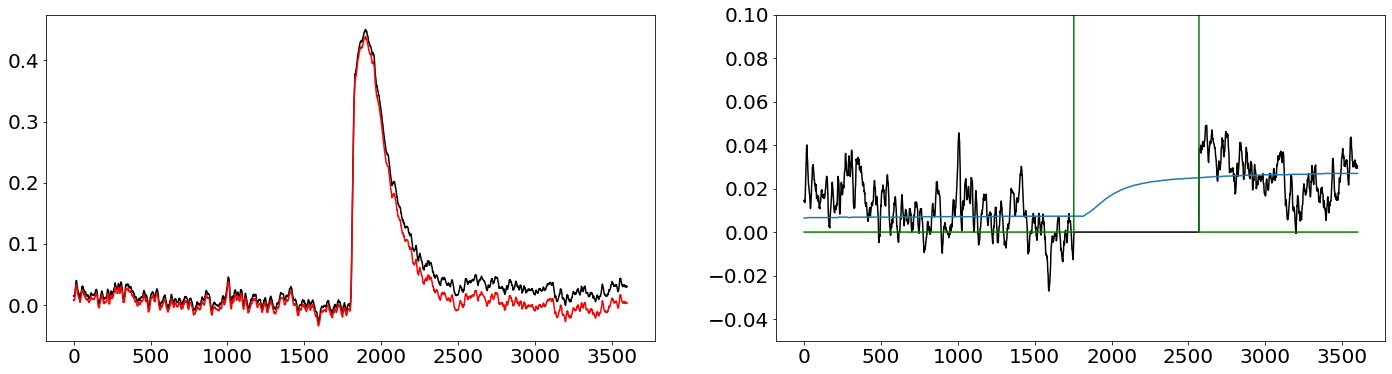

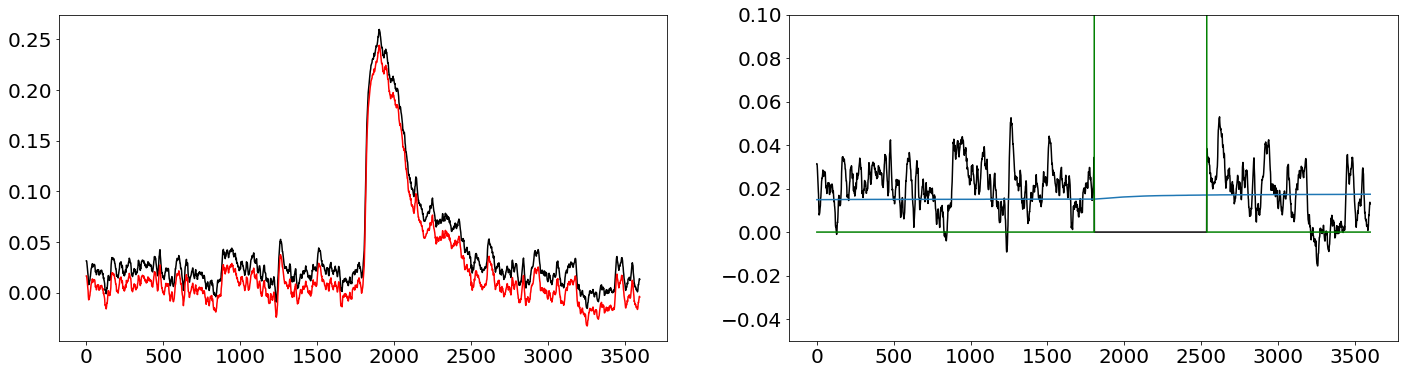

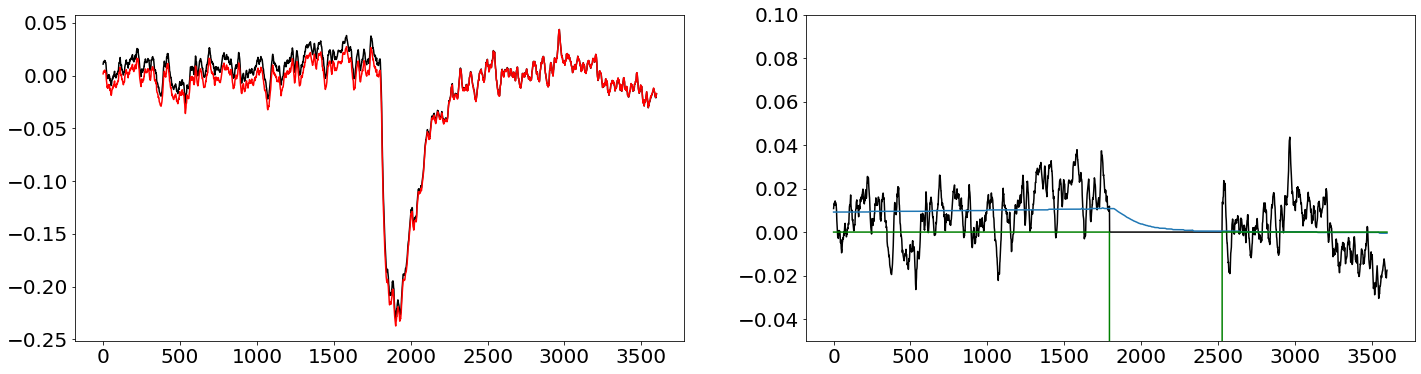

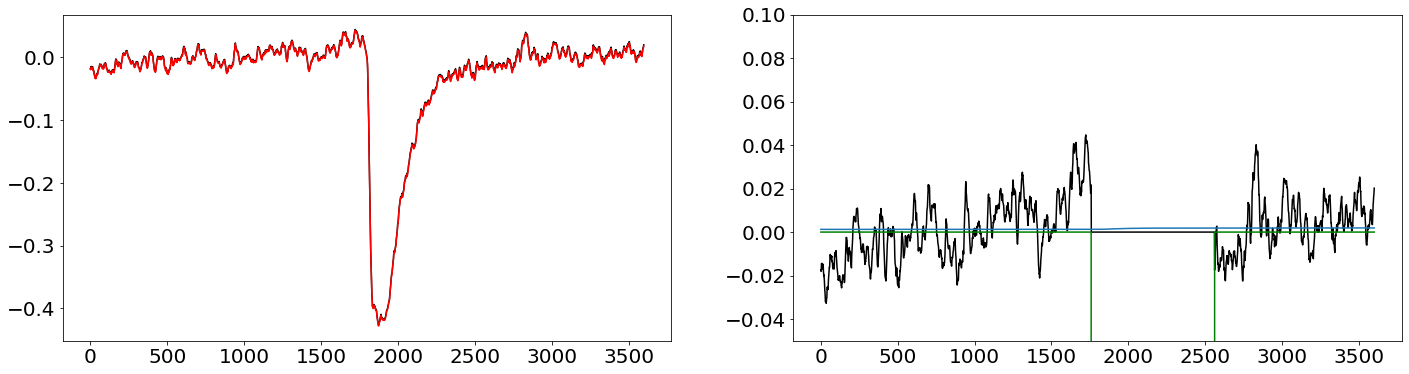

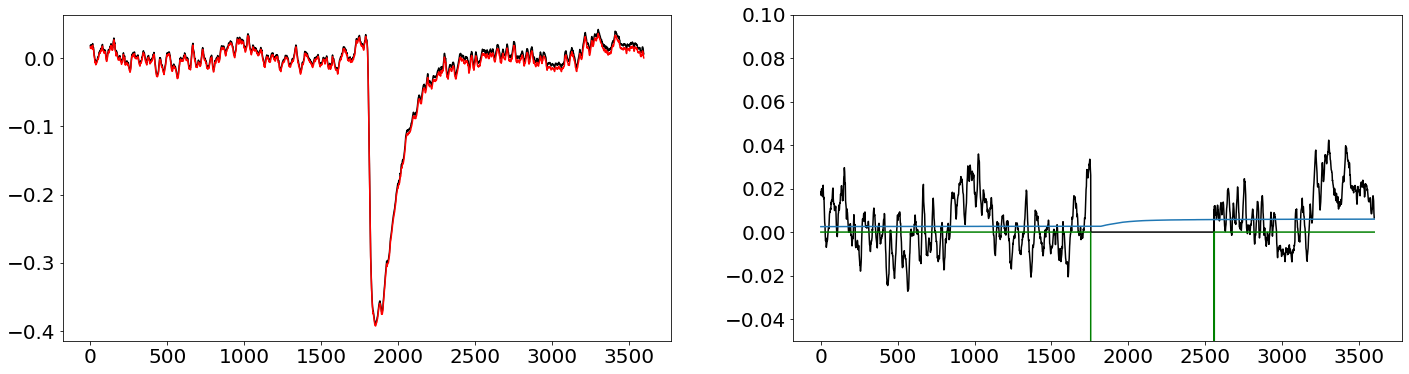

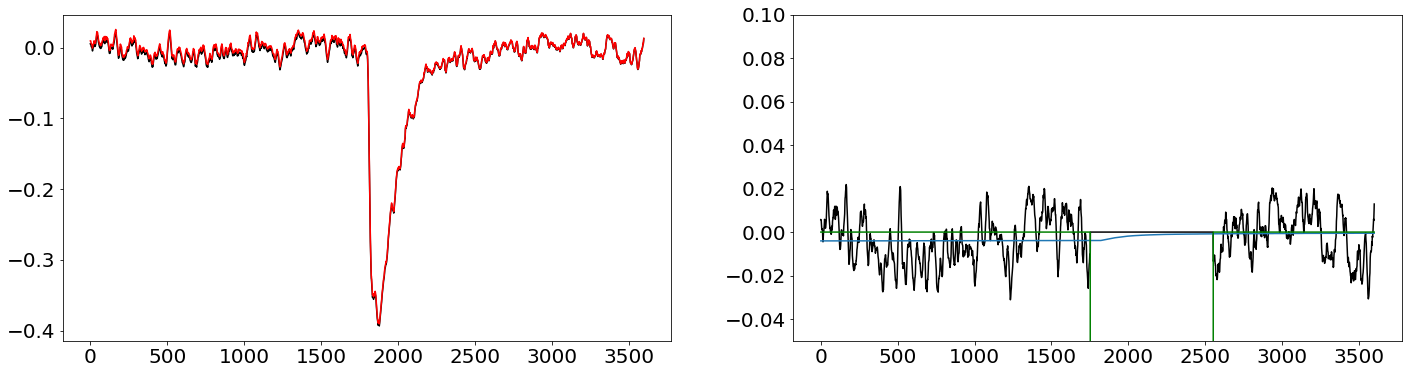

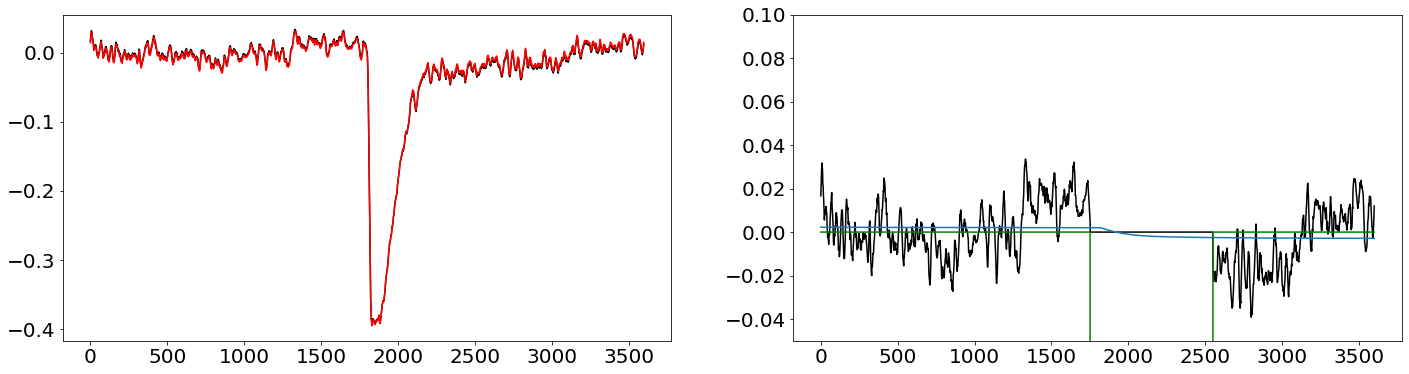

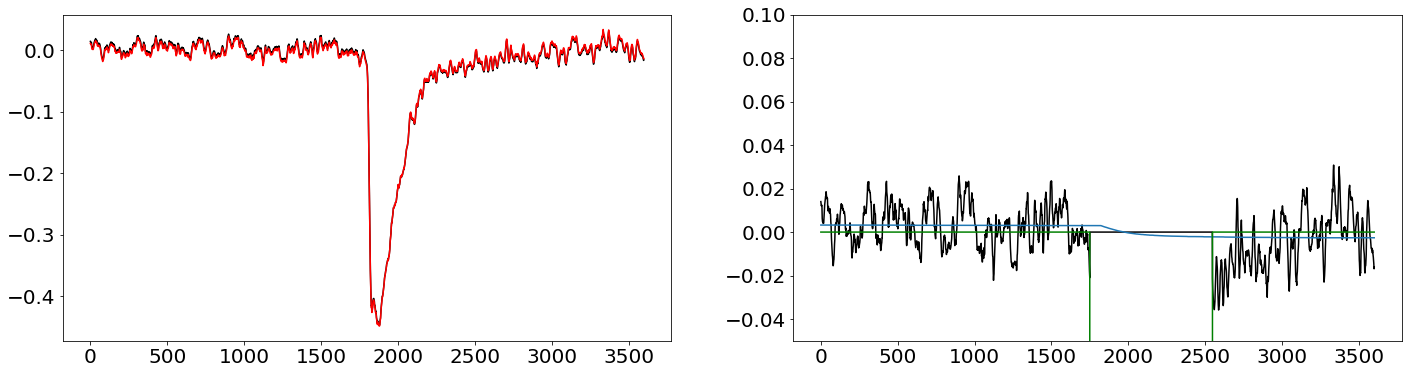

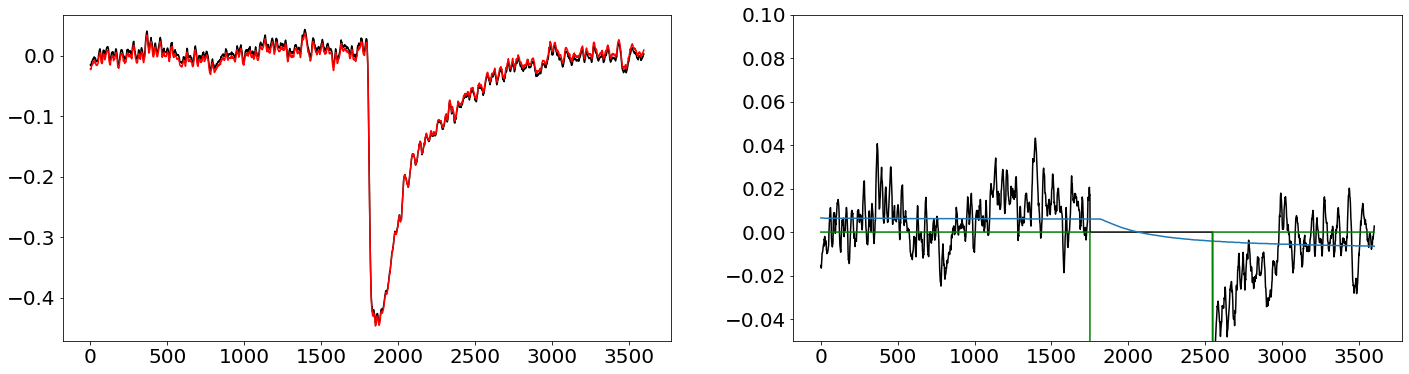

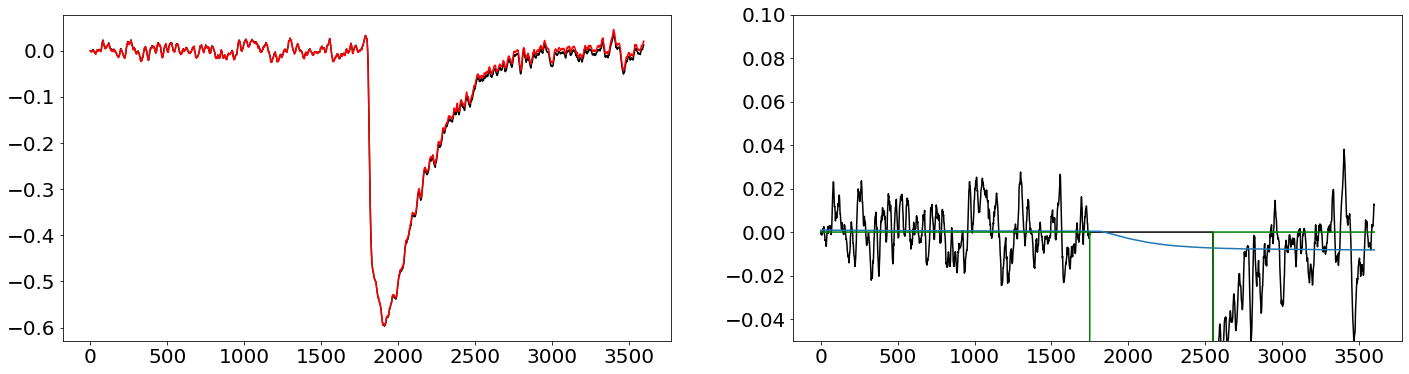

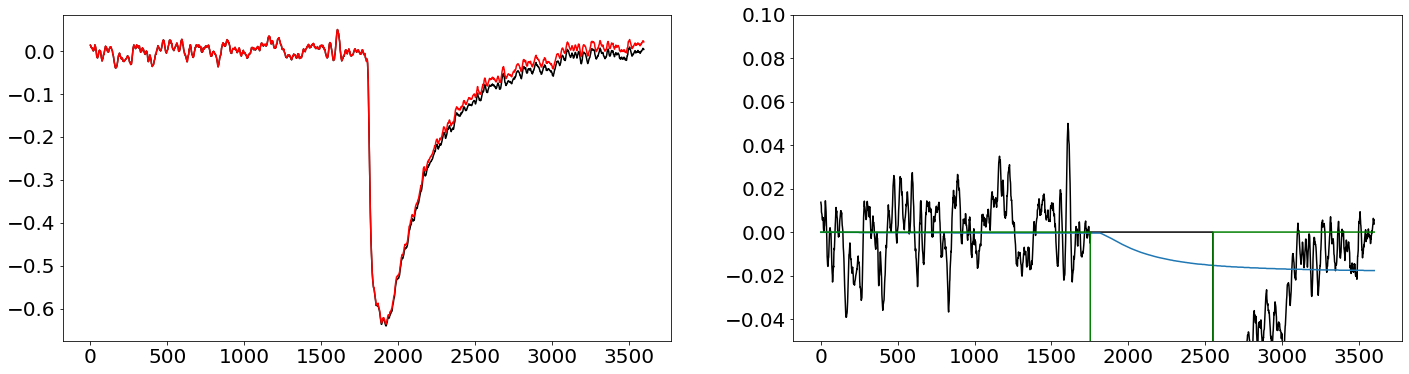

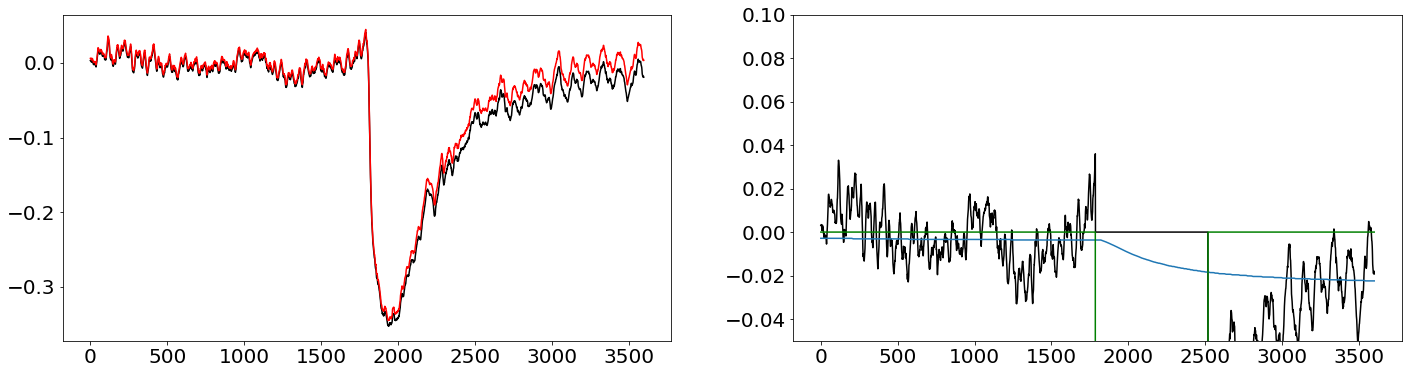

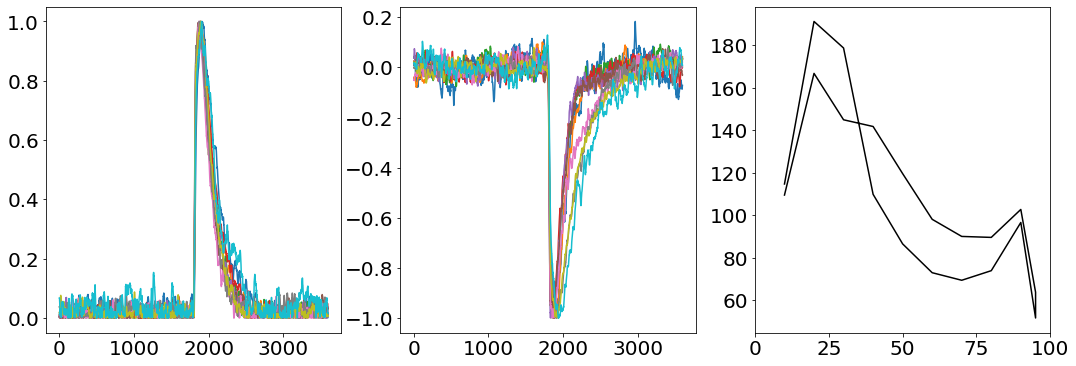

In [24]:
_, test_int = hydration_integrate(mw86D)

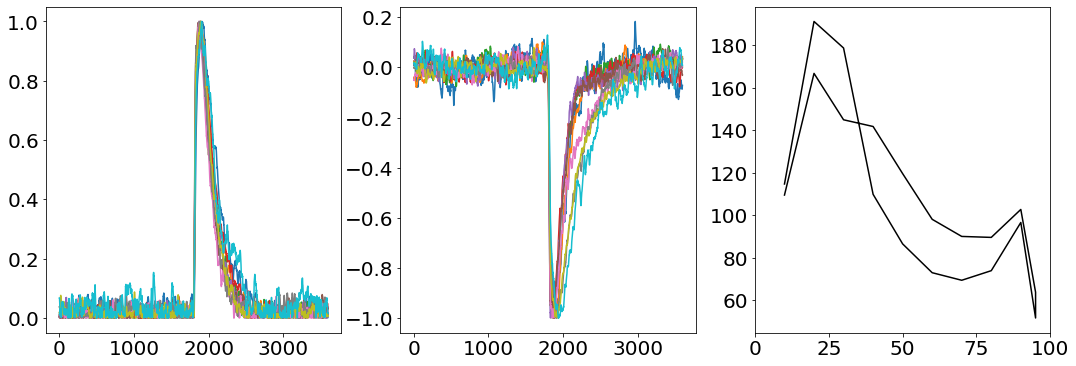

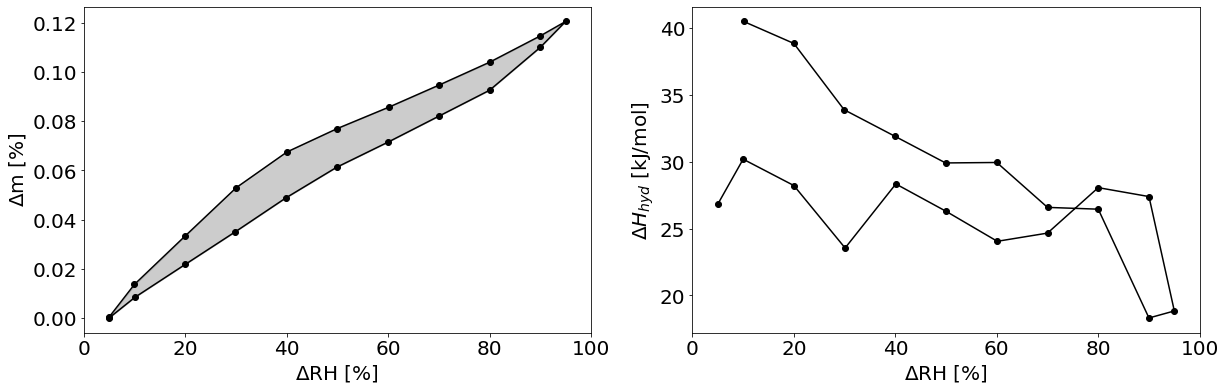

In [25]:
rh_86D, mr_86D, dH_86D = hydration_quant(mw86D);

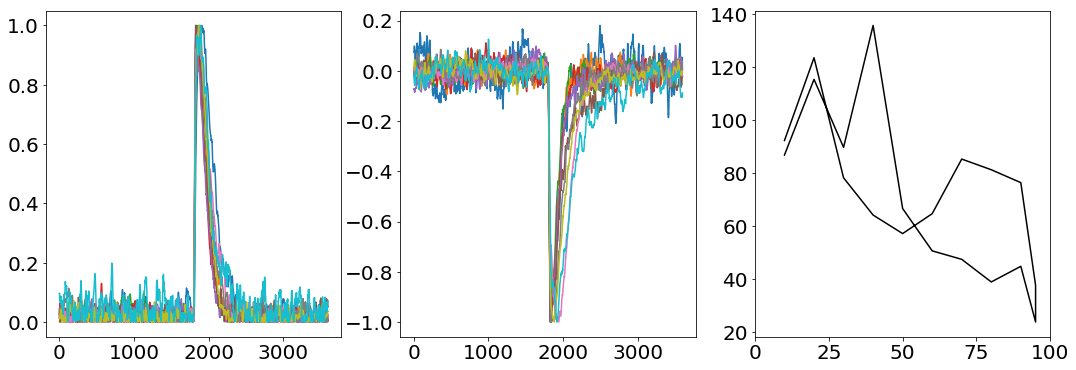

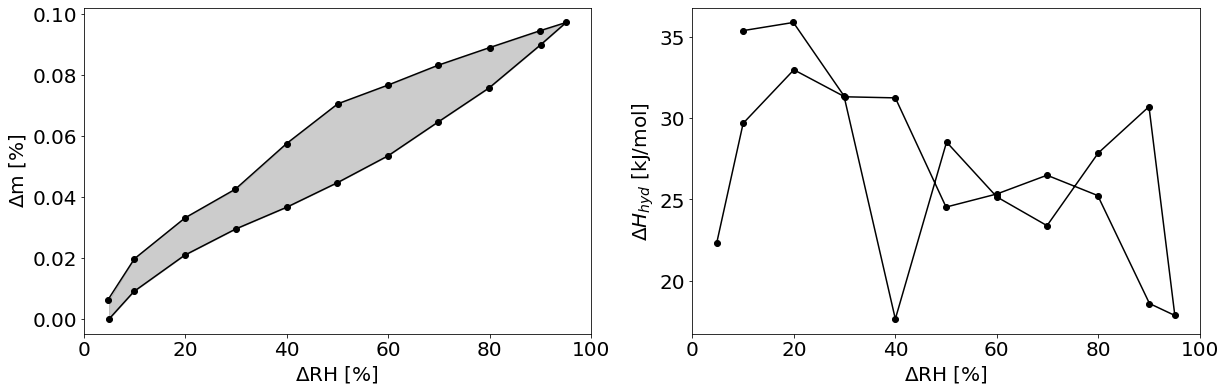

In [26]:
rh_86E, mr_86E, dH_86E = hydration_quant(mw86E);

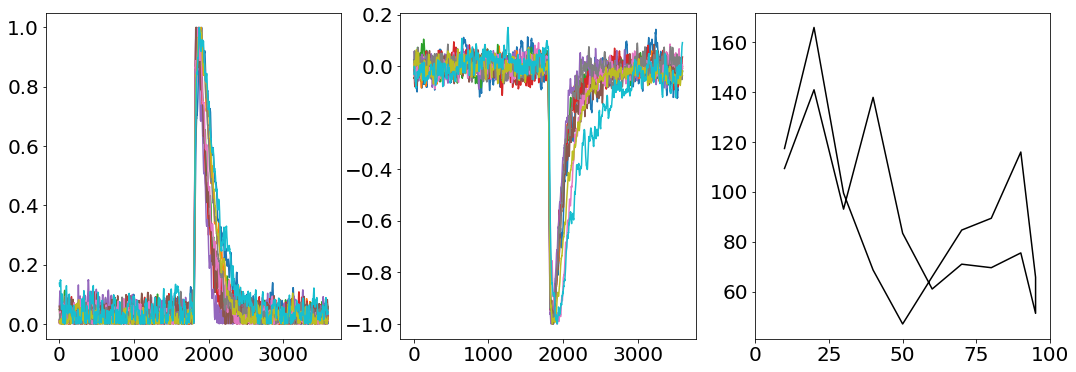

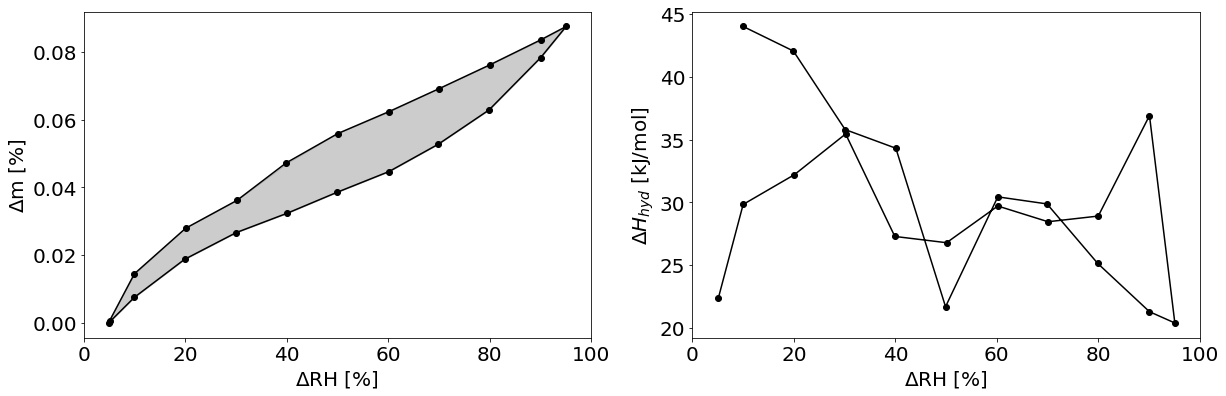

In [27]:
rh_86F, mr_86F, dH_86F = hydration_quant(mw86F);

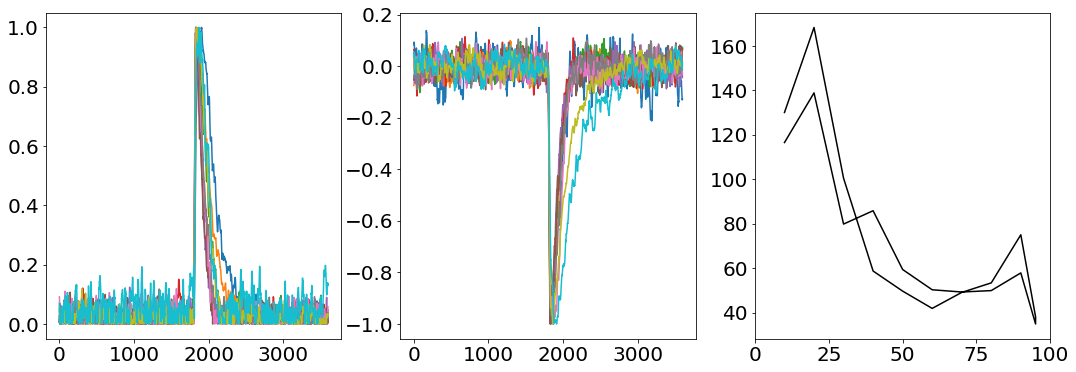

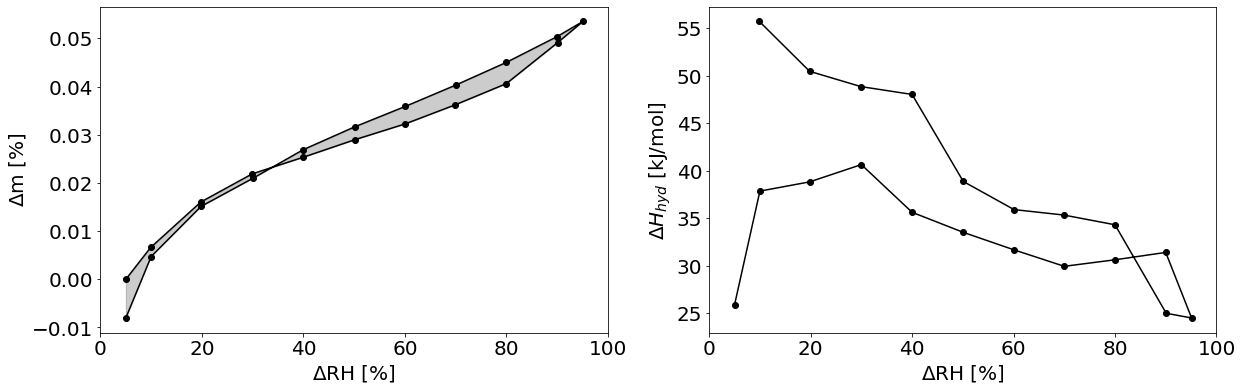

In [28]:
rh_86G, mr_86G, dH_86G = hydration_quant(mw86G);

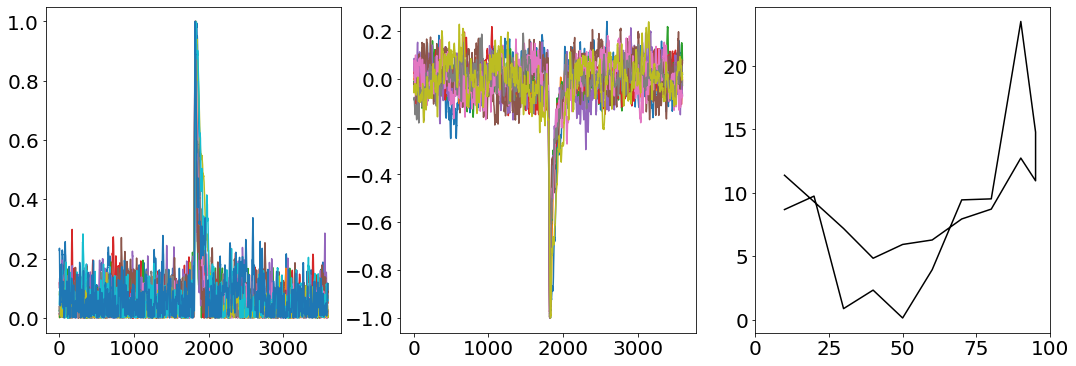

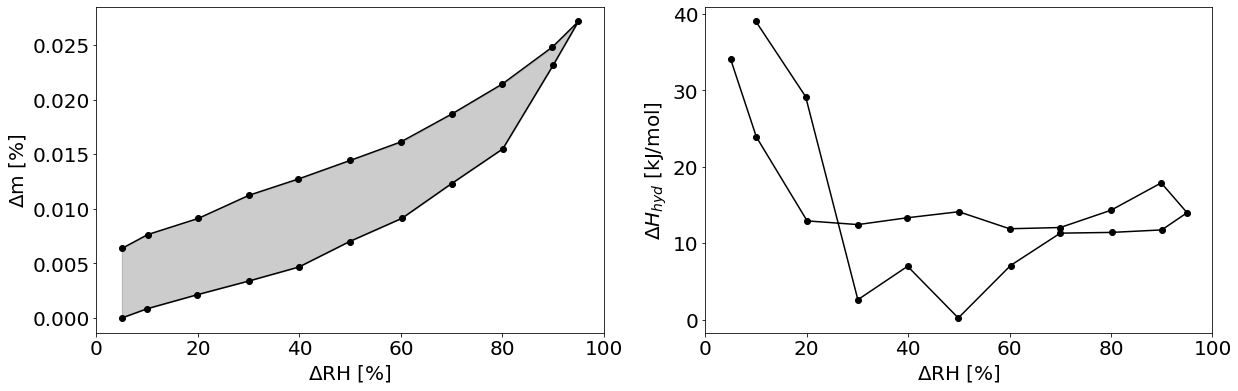

In [29]:
rh_86H, mr_86H, dH_86H = hydration_quant(mw86H);

In [30]:
def water_init(data, w_o, plot=True, start=1800, steps=20, step_size=3600):
    
    m_o = np.array(mass_steps(data['Weight'])[0])
    
    water_o = m_o[0] - w_o
    water_o_mol = water_o / 17.99
    
    m_max = np.max(data['Weight'])
    
    water_t = m_max - w_o
    
    water_t_mol = water_t / 17.99
    
    mass_percent = (m_o - w_o) / water_t
    
    #if plot:
        
    
    return water_o, water_o_mol, water_t_mol, mass_percent

In [31]:
_, _, test, mw86D_water = water_init(mw86D, 5.547)

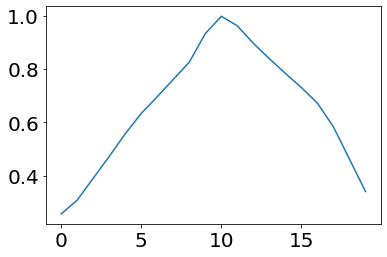

In [34]:
plt.plot(mw86D_water)

In [35]:
_, _, test, mw86E_water = water_init(mw86E, 4.747)

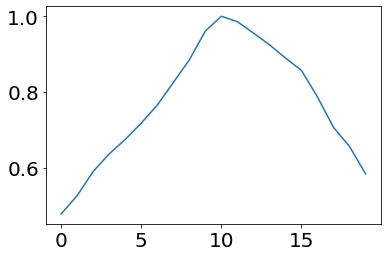

In [39]:
plt.plot(mw86E_water)

In [40]:
_, _, test, mw86F_water = water_init(mw86F, 5.864)

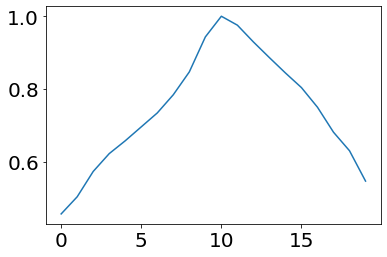

In [42]:
plt.plot(mw86F_water)

In [43]:
_, _, test, mw86G_water = water_init(mw86G, 5.970)

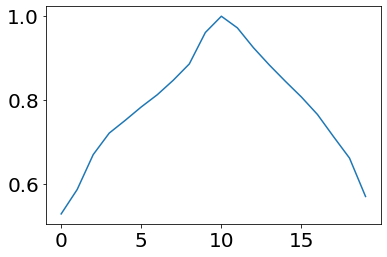

In [46]:
plt.plot(mw86G_water)

In [47]:
_, _, test, mw86H_water = water_init(mw86H, 3.859)

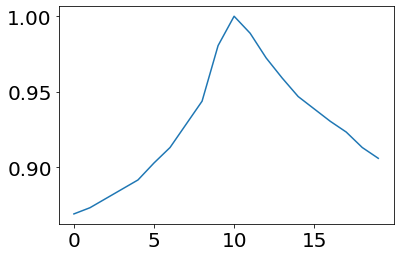

In [50]:
plt.plot(mw86H_water)

In [51]:
mass_steps(mw86H['Weight'], start=1800, steps=20, step_size=3600)[0]

[4.709,
 4.713,
 4.719,
 4.725,
 4.731,
 4.742,
 4.752,
 4.767,
 4.782,
 4.818,
 4.837,
 4.826,
 4.81,
 4.797,
 4.785,
 4.777,
 4.769,
 4.762,
 4.752,
 4.745]

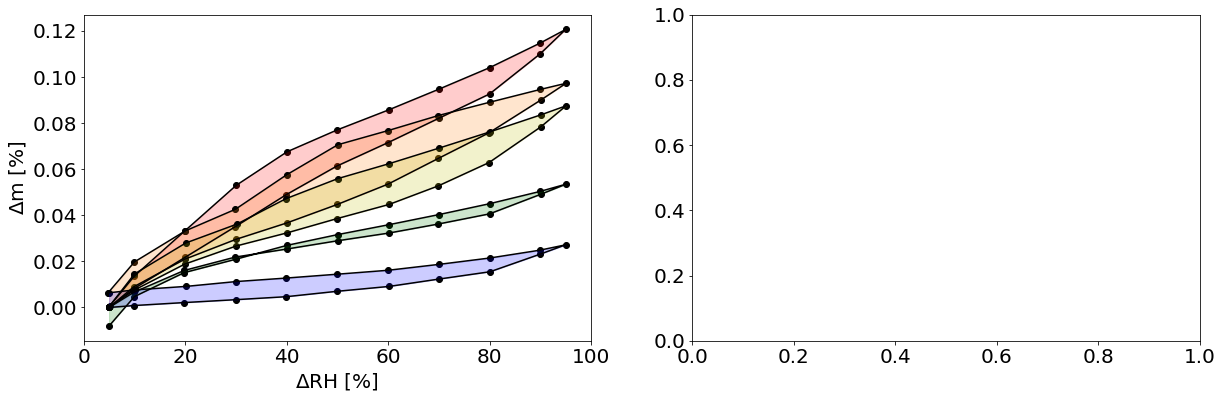

In [53]:
fig, axs = plt.subplots(1, 2, figsize=(20, 6))
plt.rcParams.update({'font.size': 20})

axs[0].plot(rh_86D, mr_86D, color='k')
axs[0].scatter(rh_86D, mr_86D, color='k')
axs[0].fill_between(rh_86D[:11], mr_86D[:11], np.flip(mr_86D[10:]), color='r', alpha=0.2)

axs[0].plot(rh_86E, mr_86E, color='k')
axs[0].scatter(rh_86E, mr_86E, color='k')
axs[0].fill_between(rh_86E[:11], mr_86E[:11], np.flip(mr_86E[10:]), color='tab:orange', alpha=0.2)

axs[0].plot(rh_86F, mr_86F, color='k')
axs[0].scatter(rh_86F, mr_86F, color='k')
axs[0].fill_between(rh_86F[:11], mr_86F[:11], np.flip(mr_86F[10:]), color='y', alpha=0.2)

axs[0].plot(rh_86G, mr_86G, color='k')
axs[0].scatter(rh_86G, mr_86G, color='k')
axs[0].fill_between(rh_86G[:11], mr_86G[:11], np.flip(mr_86G[10:]), color='g', alpha=0.2)

axs[0].plot(rh_86H, mr_86H, color='k')
axs[0].scatter(rh_86H, mr_86H, color='k')
axs[0].fill_between(rh_86H[:11], mr_86H[:11], np.flip(mr_86H[10:]), color='b', alpha=0.2)

axs[0].set_xlabel(r'$\Delta$RH [%]')
axs[0].set_ylabel(r'$\Delta$m [%]')
axs[0].set_xlim([0,100])

# axs[1].plot(rh[1:], dH, color='k')
# axs[1].scatter(rh[1:], dH, color='k')
# axs[1].set_xlabel(r'$\Delta$RH [%]')
# axs[1].set_ylabel(r'$\Delta H_{hyd}$ [kJ/mol]')

plt.show;

In [54]:
rh_86G = np.delete(rh_86G, 11)
np.trapz(dH_86G, rh_86G)

371.4370517048583

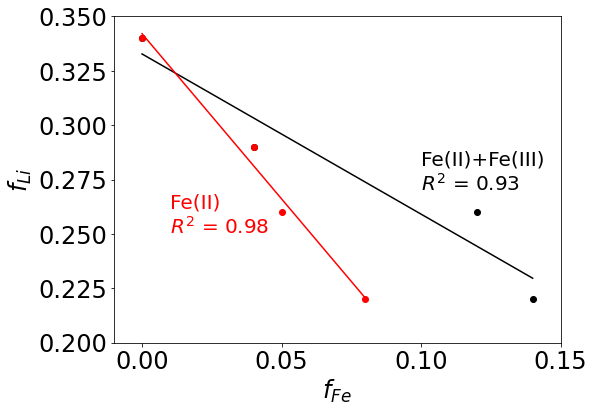

In [55]:
li_f = np.array([.22, .26, .29, .34])
fe_f = np.array([.14, .12, .04, 0])
fe2_f = np.array([.08, .05, .04, 0])
fe3_f = fe_f-fe2_f
Afe = np.vstack([fe_f, np.ones(len(fe_f))]).T
Afe2 = np.vstack([fe2_f, np.ones(len(fe2_f))]).T

fe_fit = np.linalg.lstsq(Afe, li_f, rcond=-1)
fe_line_m, fe_line_c = fe_fit[0]
fe2_fit = np.linalg.lstsq(Afe2, li_f, rcond=-1)
fe2_line_m, fe2_line_c = fe2_fit[0]

plt.rcParams["figure.figsize"] = (8,6)
plt.rcParams.update({'font.size': 24})
plt.scatter(fe_f, li_f, color='k')
plt.plot(fe_f, fe_line_m*fe_f + fe_line_c, color='k')
plt.scatter(fe2_f, li_f, color='r')
plt.plot(fe2_f, fe2_line_m*fe2_f + fe2_line_c, color='r')

plt.ylabel(r'$f_{Li}$')
plt.xlabel(r'$f_{Fe}$')
plt.ylim([.2,.35])
plt.xlim([-0.01,.15])

plt.text(.01, .25, 'Fe(II)\n$R^2$ = 0.98', fontsize = 20, color='r')
plt.text(.1, .27, 'Fe(II)+Fe(III)\n$R^2$ = 0.93', fontsize = 20, color='k')

plt.savefig("/Volumes/GoogleDrive/My Drive/Li/Figures/LDH_FeLi_comp.png",bbox_inches='tight')
plt.show;

In [56]:
1 - fe_fit[1] / (np.sum((li_f-np.mean(li_f))**2))

array([0.92620036])

In [57]:
1 - fe2_fit[1] / (np.sum((li_f-np.mean(li_f))**2))

array([0.98468309])

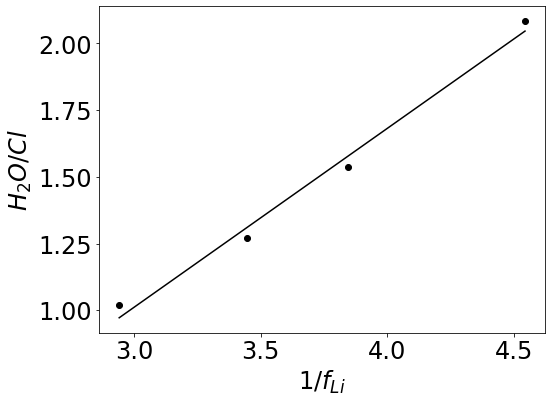

In [58]:
water_cl = np.array((50/24, 43/28, 47/37, 56/55))
water_li = np.array((0.22, 0.26, 0.29, 0.34))
water_li_r = 1 / water_li

ALi = np.vstack([water_li_r, np.ones(len(water_li_r))]).T
Lif_fit = np.linalg.lstsq(ALi, water_cl, rcond=-1)
Lif_line_m, Lif_line_c = Lif_fit[0]

plt.rcParams["figure.figsize"] = (8,6)
plt.rcParams.update({'font.size': 24})
plt.scatter(water_li_r , water_cl, color='k')
plt.plot(water_li_r , water_li_r*Lif_line_m + Lif_line_c, color='k')

plt.ylabel(r'$H_2O/Cl$')
plt.xlabel(r'$1 / f_{Li}$')

plt.savefig("/Volumes/GoogleDrive/My Drive/Li/Figures/LDH_LiWaterCl_comp.png",bbox_inches='tight')
plt.show;

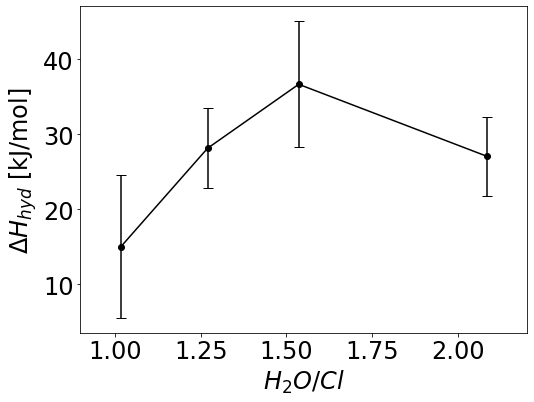

In [59]:
enthalpies = np.abs(np.array([dH_86E, dH_86G, dH_86D, dH_86H]))

plt.rcParams["figure.figsize"] = (8,6)
plt.rcParams.update({'font.size': 24})
plt.scatter(water_cl, np.mean(enthalpies, axis=1), color='k')
plt.errorbar(water_cl, np.mean(enthalpies, axis=1), np.std(enthalpies, axis=1), color='k', capsize=5)

plt.xlabel(r'$H_2O/Cl$')
plt.ylabel(r'$\Delta H_{hyd}$ [kJ/mol]')
plt.xlim([0.9, 2.2])


plt.savefig("/Volumes/GoogleDrive/My Drive/Li/Figures/LDH_enth_comp.png", bbox_inches='tight')
plt.show;

In [60]:
enthalpies[:,11]

array([27.85789202, 30.64139064, 28.05859231, 14.32044649])

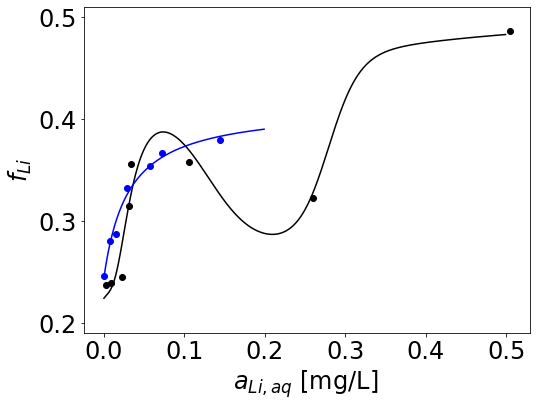

In [262]:
mw_fe = (6.94*0.29 + 26.982*0.59 + 55.845*0.12 + 35.343*0.29*1.29 + 3*(16.99)) / (1000*6.94)
mw_ldh = (6.94*0.34 + 26.982*0.66 + 35.343*0.34*1.62 + 3*(16.99)) / (1000*6.94)

LDH_iso_Fe_x = np.array([17.17, 62.524, 151.545, 215.599, 235.231, 730.224, 1800, 3500]) / (6.941*10**3)
LDH_iso_Fe_y = np.array([18.5132, 18.69904, 19.1382, 24.57604, 27.79076, 27.99104, 25.1856, 38]) * mw_fe

LDH_iso_x = np.array([0, 50, 100, 200, 400, 500, 1000]) / (6.941*10**3)
LDH_iso_y = np.array([18.81152, 21.45416, 21.99324, 25.46812, 27.12068, 28.08836, 29.0572]) * mw_ldh


# langmuir isotherm fit function
def lang(x, k, xo, a):
    return a*(k*x / (1 + k*x)) + xo

def whitt(x, B, xo, a, A1, Am, m):
    return B * ((1 + A1 + Am*np.exp(-x*a)) / (A1 + m*Am*np.exp(-x*a))) * ((x*A1 + m*Am*x**m*np.exp(-x*a)) / (1 + x*A1 + Am*x**m*np.exp(-x*a))) + xo

popt_lang, pcov_lang = curve_fit(lang, LDH_iso_x, LDH_iso_y, p0=np.array([10**-4, 0.25, .33]))
popt_whitt, pcov_whitt = curve_fit(whitt, LDH_iso_Fe_x, LDH_iso_Fe_y, p0=np.array([.25, .25, 16, 10**1, 10**6, 3.5]), bounds=(0,10**20))

plt.rcParams["figure.figsize"] = (8,6)
plt.rcParams.update({'font.size': 24})

plt.scatter(LDH_iso_Fe_x , LDH_iso_Fe_y, color='k')
ldh_x = np.arange(0,0.5,0.001)
plt.plot(ldh_x , whitt(ldh_x, *popt_whitt), color='k')

plt.scatter(LDH_iso_x , LDH_iso_y, color='b')
ldh_x = np.arange(0,0.2,0.001)
plt.plot(ldh_x , lang(ldh_x, *popt_lang), color='b')

plt.xlabel(r'$a_{Li,aq}$ [mg/L] ')
plt.ylabel(r'$f_{Li}$')
plt.ylim([0.19, 0.51])

plt.savefig("/Volumes/GoogleDrive/My Drive/Li/Figures/LDH_srob_comp.png", bbox_inches='tight')
plt.show;

In [255]:
popt_whitt

array([2.75550059e-01, 2.24249101e-01, 5.26488577e+01, 1.43871404e+01,
       7.74360346e+06, 4.26242635e+00])

In [259]:
pcov_whitt

array([[ 6.77229069e-03,  1.18902345e-03, -5.12784275e-01,
        -7.21285330e+00, -5.51317886e+06, -1.59691665e-01],
       [ 1.18902345e-03,  1.35742843e-03,  7.98635786e-01,
        -2.62259976e+00, -1.70882277e+05,  2.67695862e-03],
       [-5.12784275e-01,  7.98635786e-01,  4.22503857e+03,
         7.31342865e+01,  7.64903690e+09,  2.42836546e+02],
       [-7.21285330e+00, -2.62259976e+00,  7.31342865e+01,
         1.01939458e+04,  6.58460923e+09,  1.87060046e+02],
       [-5.51317886e+06, -1.70882277e+05,  7.64903690e+09,
         6.58460923e+09,  1.79690871e+16,  5.57089744e+08],
       [-1.59691665e-01,  2.67695862e-03,  2.42836546e+02,
         1.87060046e+02,  5.57089744e+08,  1.73371650e+01]])

In [ ]:
0.138